## Accuracy analysis of the ZED camera running in VGA@100fps (on a quadrotor)
Please scroll down to the bottom for results.
### Module imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygal
import quaternion
import seaborn as sns

from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

sns.set(style="ticks")

### $x$-translation

In [2]:
# Read and correct data.
mcp = pd.read_csv('mocap_quadrotor.csv')
mcp = mcp[['%time', 'field.pose.position.x']]
mcp.columns = ['t', 'x']
mcp['x'] = mcp.x - mcp.x[0]

zed = pd.read_csv('odom_quadrotor.csv')
zed = zed[['%time', 'field.pose.pose.position.x']]
zed.columns = ['t', 'x']
zed['x'] = (-zed.x) - (-zed.x[0])

# LERP.
x_interp = np.interp(zed.t, mcp.t, mcp.x)
mcp = pd.DataFrame(list(zip(zed.t, x_interp)), columns=['t', 'x'])

# Convert timestamps.
mcp['t'] = (mcp.t-mcp.t[0]) / 1000000000
zed['t'] = (zed.t-zed.t[0]) / 1000000000
mcp_x = mcp.copy()
zed_x = zed.copy()

### $y$-translation

In [3]:
# Read and correct data.
mcp = pd.read_csv('mocap_quadrotor.csv')
mcp = mcp[['%time', 'field.pose.position.y']]
mcp.columns = ['t', 'y']
mcp['y'] = mcp.y - mcp.y[0]

zed = pd.read_csv('odom_quadrotor.csv')
zed = zed[['%time', 'field.pose.pose.position.y']]
zed.columns = ['t', 'y']
zed['y'] = (-zed.y) - (-zed.y[0])

# LERP.
y_interp = np.interp(zed.t, mcp.t, mcp.y)
mcp = pd.DataFrame(list(zip(zed.t, y_interp)), columns=['t', 'y'])

# Convert timestamps.
mcp['t'] = (mcp.t-mcp.t[0]) / 1000000000
zed['t'] = (zed.t-zed.t[0]) / 1000000000
mcp_y = mcp.copy()
zed_y = zed.copy()

### $z$-translation

In [4]:
# Read and correct data.
mcp = pd.read_csv('mocap_quadrotor.csv')
mcp = mcp[['%time', 'field.pose.position.z']]
mcp.columns = ['t', 'z']
mcp['z'] = mcp.z - mcp.z[0]

zed = pd.read_csv('odom_quadrotor.csv')
zed = zed[['%time', 'field.pose.pose.position.z']]
zed.columns = ['t', 'z']
zed['z'] = zed.z - zed.z[0]

# LERP.
z_interp = np.interp(zed.t, mcp.t, mcp.z)
mcp = pd.DataFrame(list(zip(zed.t, z_interp)), columns=['t', 'z'])

# Convert timestamps.
mcp['t'] = (mcp.t-mcp.t[0]) / 1000000000
zed['t'] = (zed.t-zed.t[0]) / 1000000000
mcp_z = mcp.copy()
zed_z = zed.copy()

### Yaw

In [5]:
%%time

# Read and correct data.
mcp = pd.read_csv('mocap_quadrotor.csv')
mcp = mcp[['%time',
           'field.pose.orientation.x',
           'field.pose.orientation.y',
           'field.pose.orientation.z',
           'field.pose.orientation.w']]
mcp.columns = ['t', 'x', 'y', 'z', 'w']  # Rename columns.

zed = pd.read_csv('odom_quadrotor.csv')
zed = zed[['%time',
           'field.pose.pose.orientation.x',
           'field.pose.pose.orientation.y',
           'field.pose.pose.orientation.z',
           'field.pose.pose.orientation.w']]
zed.columns = ['t', 'x', 'y', 'z', 'w']  # Rename columns.

# Transform to the correct coordinate.
q_tf = quaternion.from_euler_angles(0, 0, np.deg2rad(-178.37))
tf_ls = list()

# Apply to the mocap rotational data.
for i in mcp.index:
    tmp_ln = mcp.iloc[i, :]
    q_0 = np.quaternion(tmp_ln.w,
                        tmp_ln.x,
                        tmp_ln.y,
                        tmp_ln.z)    
    q_1 = q_tf * q_0
    tf_ls.append((q_1.x, q_1.y, q_1.z, q_1.w))

tmp_q_df = pd.DataFrame(tf_ls, columns=['x', 'y', 'z', 'w'])
mcp.x = tmp_q_df.x
mcp.y = tmp_q_df.y
mcp.z = tmp_q_df.z
mcp.w = tmp_q_df.w

# Extract Euler angles.
mcp_yaw = np.rad2deg(
    np.arctan2(2*(mcp.w*mcp.z+mcp.x*mcp.y), 1-2*(mcp.y**2+mcp.z**2)))
zed_yaw = np.rad2deg(
    np.arctan2(2*(zed.w*zed.z+zed.x*zed.y), 1-2*(zed.y**2+zed.z**2)))

mcp_yaw = pd.DataFrame(list(zip(mcp.t, mcp_yaw)), columns=['t', 'yaw'])
zed_yaw = pd.DataFrame(list(zip(zed.t, zed_yaw)), columns=['t', 'yaw'])

CPU times: user 26.6 s, sys: 296 ms, total: 26.9 s
Wall time: 27 s


### Pitch

In [6]:
%%time

# Read and correct data.
mcp = pd.read_csv('mocap_quadrotor.csv')
mcp = mcp[['%time',
           'field.pose.orientation.x',
           'field.pose.orientation.y',
           'field.pose.orientation.z',
           'field.pose.orientation.w']]
mcp.columns = ['t', 'x', 'y', 'z', 'w']  # Rename columns.

zed = pd.read_csv('odom_quadrotor.csv')
zed = zed[['%time',
           'field.pose.pose.orientation.x',
           'field.pose.pose.orientation.y',
           'field.pose.pose.orientation.z',
           'field.pose.pose.orientation.w']]
zed.columns = ['t', 'x', 'y', 'z', 'w']  # Rename columns.

# Transform to the correct coordinate.
q_tf = quaternion.from_euler_angles(np.deg2rad(-178.37), 0, np.deg2rad(-178.37))
tf_ls = list()

# Apply to the mocap rotational data.
for i in mcp.index:
    tmp_ln = mcp.iloc[i, :]
    q_0 = np.quaternion(tmp_ln.w,
                        tmp_ln.x,
                        tmp_ln.y,
                        tmp_ln.z)    
    q_1 = q_tf * q_0
    tf_ls.append((q_1.x, q_1.y, q_1.z, q_1.w))

tmp_q_df = pd.DataFrame(tf_ls, columns=['x', 'y', 'z', 'w'])
mcp.x = tmp_q_df.x
mcp.y = tmp_q_df.y
mcp.z = tmp_q_df.z
mcp.w = tmp_q_df.w

# Extract Euler angles.
mcp_pitch = np.rad2deg(np.arcsin(2*(mcp.w*mcp.y-mcp.z*mcp.x)))
zed_pitch = np.rad2deg(np.arcsin(2*(zed.w*zed.y-zed.z*zed.x)))

mcp_pitch = pd.DataFrame(list(zip(mcp.t, mcp_pitch)), columns=['t', 'pitch'])
zed_pitch = pd.DataFrame(list(zip(zed.t, zed_pitch)), columns=['t', 'pitch'])

CPU times: user 28 s, sys: 326 ms, total: 28.3 s
Wall time: 28.6 s


### Roll

In [7]:
%%time

# Read and correct data.
mcp = pd.read_csv('mocap_quadrotor.csv')
mcp = mcp[['%time',
           'field.pose.orientation.x',
           'field.pose.orientation.y',
           'field.pose.orientation.z',
           'field.pose.orientation.w']]
mcp.columns = ['t', 'x', 'y', 'z', 'w']  # Rename columns.

zed = pd.read_csv('odom_quadrotor.csv')
zed = zed[['%time',
           'field.pose.pose.orientation.x',
           'field.pose.pose.orientation.y',
           'field.pose.pose.orientation.z',
           'field.pose.pose.orientation.w']]
zed.columns = ['t', 'x', 'y', 'z', 'w']  # Rename columns.

# Transform to the correct coordinate.
q_tf = quaternion.from_euler_angles(np.deg2rad(-178.37), 0, np.deg2rad(-178.37))
tf_ls = list()

# Apply to the mocap rotational data.
for i in mcp.index:
    tmp_ln = mcp.iloc[i, :]
    q_0 = np.quaternion(tmp_ln.w,
                        tmp_ln.x,
                        tmp_ln.y,
                        tmp_ln.z)    
    q_1 = q_tf * q_0
    tf_ls.append((q_1.x, q_1.y, q_1.z, q_1.w))

tmp_q_df = pd.DataFrame(tf_ls, columns=['x', 'y', 'z', 'w'])
mcp.x = tmp_q_df.x
mcp.y = tmp_q_df.y
mcp.z = tmp_q_df.z
mcp.w = tmp_q_df.w

# Extract Euler angles.
mcp_roll = np.rad2deg(
    np.arctan2(2*(mcp.w*mcp.x+mcp.y*mcp.z), 1-2*(mcp.x**2+mcp.y**2)))
zed_roll = np.rad2deg(
    np.arctan2(2*(zed.w*zed.x+zed.y*zed.z), 1-2*(zed.x**2+zed.y**2)))

mcp_roll = pd.DataFrame(list(zip(mcp.t, mcp_roll)), columns=['t', 'roll'])
zed_roll = pd.DataFrame(list(zip(zed.t, zed_roll)), columns=['t', 'roll'])

CPU times: user 34.4 s, sys: 471 ms, total: 34.8 s
Wall time: 35 s


### Plots

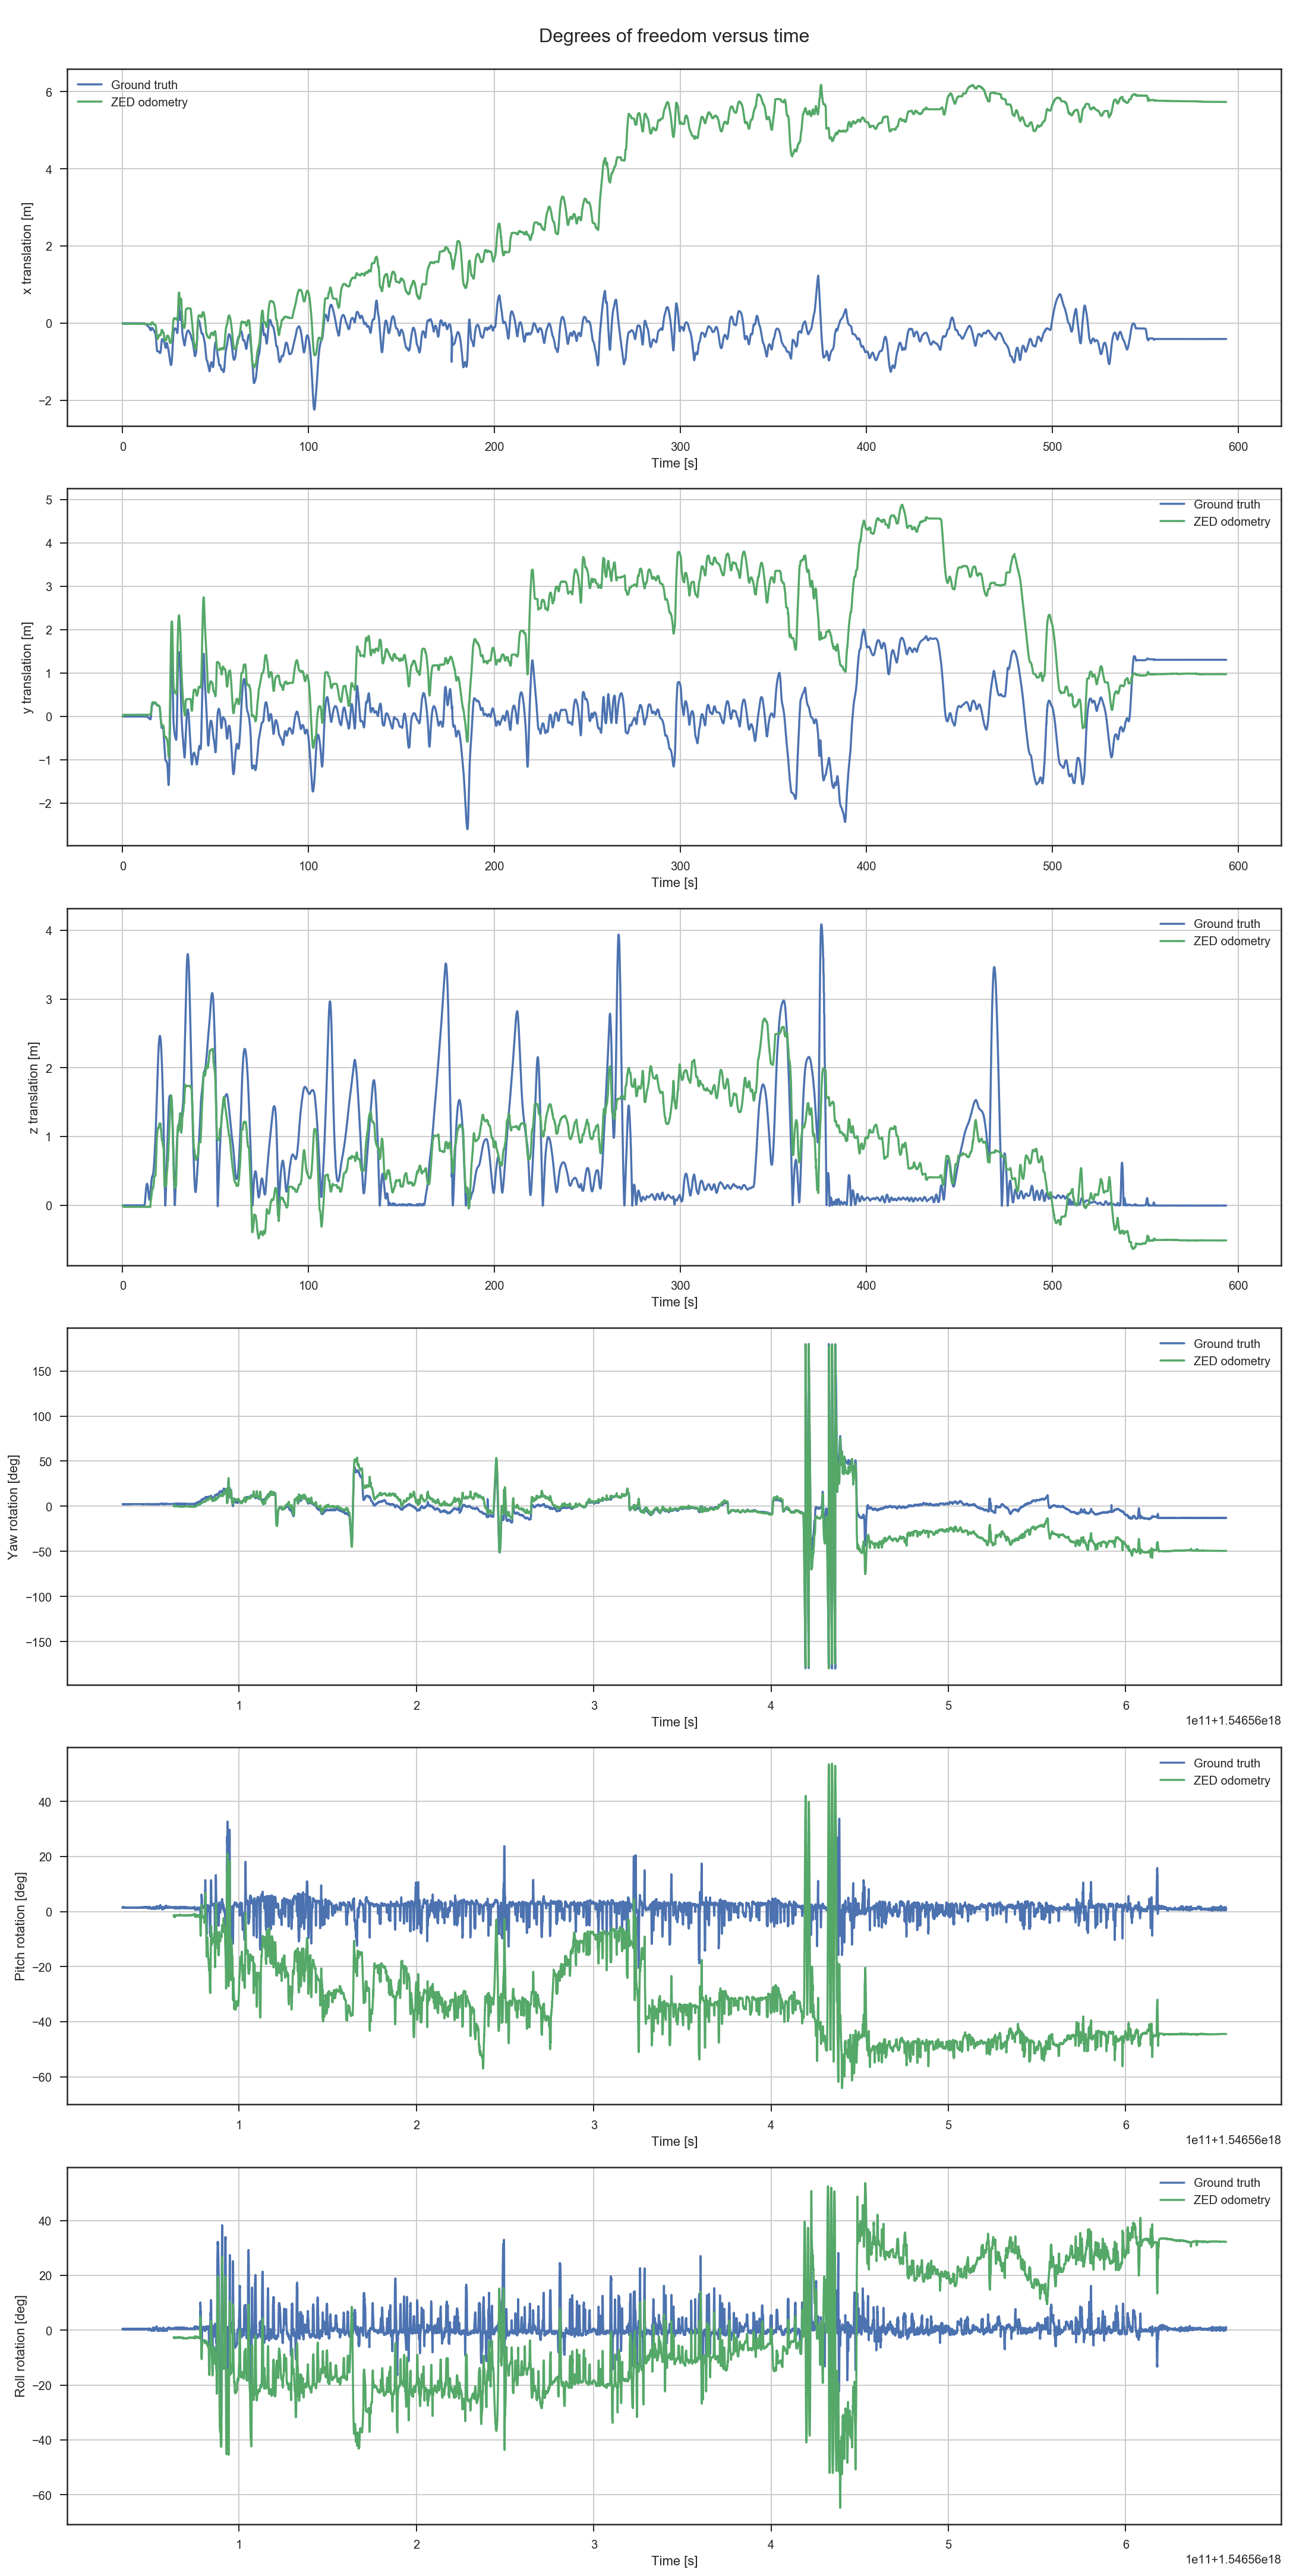

In [8]:
# Plot using matplotlib.
fig, ax = plt.subplots(6, 1,
                       figsize=(15, 30),
                       sharex=False, sharey=False,
                       constrained_layout=True)

label_mcp = 'Ground truth'
label_zed = 'ZED odometry'

ax[0].plot(mcp_x.t, mcp_x.x, label=label_mcp)
ax[0].plot(zed_x.t, zed_x.x, label=label_zed)
ax[0].legend()
ax[0].grid()
ax[0].set_title('\nDegrees of freedom versus time\n', fontsize=16)
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('x translation [m]')

ax[1].plot(mcp_y.t, mcp_y.y, label=label_mcp)
ax[1].plot(zed_y.t, zed_y.y, label=label_zed)
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('y translation [m]')

ax[2].plot(mcp_z.t, mcp_z.z, label=label_mcp)
ax[2].plot(zed_z.t, zed_z.z, label=label_zed)
ax[2].legend()
ax[2].grid()
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('z translation [m]')

ax[3].plot(mcp_yaw.t, mcp_yaw.yaw, label=label_mcp)
ax[3].plot(zed_yaw.t, zed_yaw.yaw, label=label_zed)
ax[3].legend()
ax[3].grid()
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Yaw rotation [deg]')

ax[4].plot(mcp_pitch.t, mcp_pitch.pitch, label=label_mcp)
ax[4].plot(zed_pitch.t, zed_pitch.pitch, label=label_zed)
ax[4].legend()
ax[4].grid()
ax[4].set_xlabel('Time [s]')
ax[4].set_ylabel('Pitch rotation [deg]')

ax[5].plot(mcp_roll.t, mcp_roll.roll, label=label_mcp)
ax[5].plot(zed_roll.t, zed_roll.roll, label=label_zed)
ax[5].legend()
ax[5].grid()
ax[5].set_xlabel('Time [s]')
ax[5].set_ylabel('Roll rotation [deg]')

plt.show()